In [15]:
# ==========================================================
# 0. IMPORTS
# ==========================================================
import warnings
warnings.filterwarnings("ignore")

import itertools
import math
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, MultiHeadAttention,
    Dropout, Flatten, Layer, Conv1D
)
from tensorflow.keras import regularizers

# ==========================================================
# 1. HELPERS (PARSE + SEQUENCES)
# ==========================================================
def _parse_volume(v):
    """Parse volume strings like '59.11M', '120.5K', '1.2B' into floats."""
    if pd.isna(v):
        return np.nan
    s = str(v).strip().replace(',', '')
    if s in ['', '-', 'nan', 'None']:
        return np.nan
    mult = 1.0
    if s.endswith(('K','k')):
        mult = 1e3
        s = s[:-1]
    elif s.endswith(('M','m')):
        mult = 1e6
        s = s[:-1]
    elif s.endswith(('B','b')):
        mult = 1e9
        s = s[:-1]
    try:
        return float(s) * mult
    except:
        return np.nan

def _parse_pct(p):
    """Parse percentage strings like '2.12%' into decimal 0.0212."""
    if pd.isna(p):
        return np.nan
    s = str(p).strip().replace('%','')
    if s in ['', '-', 'nan', 'None']:
        return np.nan
    try:
        return float(s)/100.0
    except:
        return np.nan

def create_sequences(data, lookback):
    """
    data: (T, num_features+1) where last col is target.
    returns:
        X: (N, lookback, num_features)
        y: (N,)
    """
    X, y = [], []
    num_features = data.shape[1] - 1
    for i in range(len(data) - lookback):
        seq_x = data[i:i+lookback, :num_features]
        seq_y = data[i+lookback, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# ==========================================================
# 2. POSITIONAL ENCODING LAYER (FOR TRANSFORMER)
# ==========================================================
class PositionalEncoding(Layer):
    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def call(self, x):
        seq_len = tf.shape(x)[1]
        d_model = tf.shape(x)[2]

        positions = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]   # (seq_len, 1)
        dims      = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]  # (1, d_model)

        angle_rates = 1.0 / tf.pow(10000.0, (2 * (dims // 2)) / tf.cast(d_model, tf.float32))
        angle_rads  = positions * angle_rates

        sines   = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)

        return x + pos_encoding


# ==========================================================
# 3. SHARED DATA PROCESSING
# ==========================================================

# ---- 3.1 Load + clean base dataframe ----
CSV_PATH = '/mnt/d/Year 4/AISE 4410 Time Series ML/WSLFolder/AAPL_Data.csv'   # <-- change if needed
df_all = pd.read_csv(CSV_PATH)

# Clean Date
df_all["Date"] = pd.to_datetime(df_all["Date"].astype(str).str.strip(), errors="coerce")
df_all = df_all.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# Make sure columns exist
needed_cols = ["Open", "High", "Low", "Price", "Vol.", "Change %"]
missing = [c for c in needed_cols if c not in df_all.columns]
if missing:
    raise ValueError(f"Your CSV is missing columns: {missing}")

# Numeric conversion for prices
for c in ["Open", "High", "Low", "Price"]:
    df_all[c] = pd.to_numeric(df_all[c], errors="coerce")

# Volume + percentage
df_all["Vol."]      = df_all["Vol."].apply(_parse_volume)
df_all["Change %"]  = df_all["Change %"].apply(_parse_pct)

df_all = df_all.dropna(subset=["Open", "High", "Low", "Price", "Vol.", "Change %"]).reset_index(drop=True)

print(f"Cleaned data: {len(df_all)} rows from {df_all['Date'].min()} to {df_all['Date'].max()}")

feature_columns = ["Open", "High", "Low", "Vol.", "Change %"]
target_column   = "Price"

# ---- 3.2 SARIMA univariate monthly series ----
df_sarima = df_all.set_index("Date").sort_index()
y_price_daily = df_sarima["Price"].astype(float)

# Monthly resampling (last observation each month)
y_m = y_price_daily.resample("M").last().dropna()

# Log transform
y_log = np.log(y_m)

# Train/test split (last ~5% as test, same as original)
train_size_sar = int(len(y_log) * 0.967)
y_train_sar = y_log.iloc[:train_size_sar]
y_test_sar  = y_log.iloc[train_size_sar:]

print("\n[SARIMA] Total monthly points:", len(y_log))
print("[SARIMA] Train points:", len(y_train_sar))
print("[SARIMA] Test points :", len(y_test_sar))

# ---- 3.3 Deep learning daily splits + scaling (shared for Transformer & TCN) ----
n = len(df_all)
train_size = int(n * 0.90)
val_size   = int(n * 0.05)
test_size  = n - train_size - val_size

train_df = df_all.iloc[:train_size]
val_df   = df_all.iloc[train_size:train_size + val_size]
test_df  = df_all.iloc[train_size + val_size:]

print(f"\n[DL] Train rows: {len(train_df)}, Val rows: {len(val_df)}, Test rows: {len(test_df)}")

# Fit scalers only on train
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target   = MinMaxScaler(feature_range=(0, 1))

X_train_raw = train_df[feature_columns].values
y_train_raw = train_df[target_column].values.reshape(-1, 1)

scaler_features.fit(X_train_raw)
scaler_target.fit(y_train_raw)

X_train_scaled = scaler_features.transform(X_train_raw)
y_train_scaled = scaler_target.transform(y_train_raw)

X_val_scaled = scaler_features.transform(val_df[feature_columns].values)
y_val_scaled = scaler_target.transform(val_df[target_column].values.reshape(-1, 1))

X_test_scaled = scaler_features.transform(test_df[feature_columns].values)
y_test_scaled = scaler_target.transform(test_df[target_column].values.reshape(-1, 1))

# Stack features + target (last column) to make sequence building easier
train_scaled_data = np.column_stack([X_train_scaled, y_train_scaled])
val_scaled_data   = np.column_stack([X_val_scaled,   y_val_scaled])
test_scaled_data  = np.column_stack([X_test_scaled,  y_test_scaled])

print("train_scaled_data shape:", train_scaled_data.shape)
print("val_scaled_data shape:  ", val_scaled_data.shape)
print("test_scaled_data shape: ", test_scaled_data.shape)

# ---- 3.4 Build sequences for each DL model separately ----
# Transformer: shorter lookback (as in your code)
TIME_STEP_TRANS = 15

X_train_tf, y_train_tf = create_sequences(train_scaled_data, TIME_STEP_TRANS)
X_val_tf,   y_val_tf   = create_sequences(val_scaled_data,   TIME_STEP_TRANS)
X_test_tf,  y_test_tf  = create_sequences(test_scaled_data,  TIME_STEP_TRANS)

print("\n[Transformer] X_train_tf shape:", X_train_tf.shape, "y_train_tf:", y_train_tf.shape)
print("[Transformer] X_val_tf shape:  ", X_val_tf.shape,   "y_val_tf:  ", y_val_tf.shape)
print("[Transformer] X_test_tf shape: ", X_test_tf.shape,  "y_test_tf: ", y_test_tf.shape)

# TCN: longer lookback (as in your TCN code)
LOOKBACK_TCN = 30

X_train_tcn, y_train_tcn = create_sequences(train_scaled_data, LOOKBACK_TCN)
X_val_tcn,   y_val_tcn   = create_sequences(val_scaled_data,   LOOKBACK_TCN)
X_test_tcn,  y_test_tcn  = create_sequences(test_scaled_data,  LOOKBACK_TCN)

print("\n[TCN] X_train_tcn shape:", X_train_tcn.shape, "y_train_tcn:", y_train_tcn.shape)
print("[TCN] X_val_tcn shape:  ", X_val_tcn.shape,   "y_val_tcn:  ", y_val_tcn.shape)
print("[TCN] X_test_tcn shape: ", X_test_tcn.shape,  "y_test_tcn: ", y_test_tcn.shape)

import sys
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Force Jupyter / VSCode to never truncate stdout
sys.setrecursionlimit(10000)

Cleaned data: 10909 rows from 1980-12-12 00:00:00 to 2024-03-27 00:00:00

[SARIMA] Total monthly points: 520
[SARIMA] Train points: 502
[SARIMA] Test points : 18

[DL] Train rows: 9818, Val rows: 545, Test rows: 546
train_scaled_data shape: (9818, 6)
val_scaled_data shape:   (545, 6)
test_scaled_data shape:  (546, 6)

[Transformer] X_train_tf shape: (9803, 15, 5) y_train_tf: (9803,)
[Transformer] X_val_tf shape:   (530, 15, 5) y_val_tf:   (530,)
[Transformer] X_test_tf shape:  (531, 15, 5) y_test_tf:  (531,)

[TCN] X_train_tcn shape: (9788, 30, 5) y_train_tcn: (9788,)
[TCN] X_val_tcn shape:   (515, 30, 5) y_val_tcn:   (515,)
[TCN] X_test_tcn shape:  (516, 30, 5) y_test_tcn:  (516,)


### SARIMA Model (Summary)

Goal: Predict next stock continuously for roughly 545 days price using classical time-series decomposition with seasonality (12-month cycle)
Data Preprocessing:
resampled daily prices to monthly last prices
applied log transform for variance stabilization
Architecture:
SARIMA(p, d, q) × (P, D, Q, s)
– with hyperparameters selected based on lowest AIC.
  
values used for each parameter: p (0, 1, 2), d (1), q (0, 1, 2), p(0, 1), D (1), Q (0, 1), s (12)
Pros: 
Captures trend + seasonal structure (12-month financial cycles)
Naturally models volatility and drawdowns better than deep learning models
Good for low frequency (monthly) signals
Residual diagonstics available (ACF/PACF)
Cons:
Limited long horizon predicitive power -> has difficulties predicting past 2 years
Assumes linear relatinoships (for this reason a log transform was applied)
Parameter tuning is expensive (grid search)
underperforms when large unpredictable changes in the markets occur i.e. market crashes


Starting SARIMA grid search...

SARIMA(0, 1, 0)x(0, 1, 0, 12)12 → AIC = -280.95
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 → AIC = -572.26
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 → AIC = -401.04
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 → AIC = -570.06
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 → AIC = -286.16
SARIMA(0, 1, 1)x(0, 1, 1, 12)12 → AIC = -572.52
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 → AIC = -404.34
SARIMA(0, 1, 1)x(1, 1, 1, 12)12 → AIC = -570.60
SARIMA(0, 1, 2)x(0, 1, 0, 12)12 → AIC = -283.15
SARIMA(0, 1, 2)x(0, 1, 1, 12)12 → AIC = -569.50
SARIMA(0, 1, 2)x(1, 1, 0, 12)12 → AIC = -402.75
SARIMA(0, 1, 2)x(1, 1, 1, 12)12 → AIC = -567.62
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 → AIC = -288.02
SARIMA(1, 1, 0)x(0, 1, 1, 12)12 → AIC = -573.59
SARIMA(1, 1, 0)x(1, 1, 0, 12)12 → AIC = -410.77
SARIMA(1, 1, 0)x(1, 1, 1, 12)12 → AIC = -571.61
SARIMA(1, 1, 1)x(0, 1, 0, 12)12 → AIC = -284.54
SARIMA(1, 1, 1)x(0, 1, 1, 12)12 → AIC = -571.30
SARIMA(1, 1, 1)x(1, 1, 0, 12)12 → AIC = -408.82
SARIMA(1, 1, 1)x(1, 1, 1, 12)12 → AIC = -569.15
SARIMA(

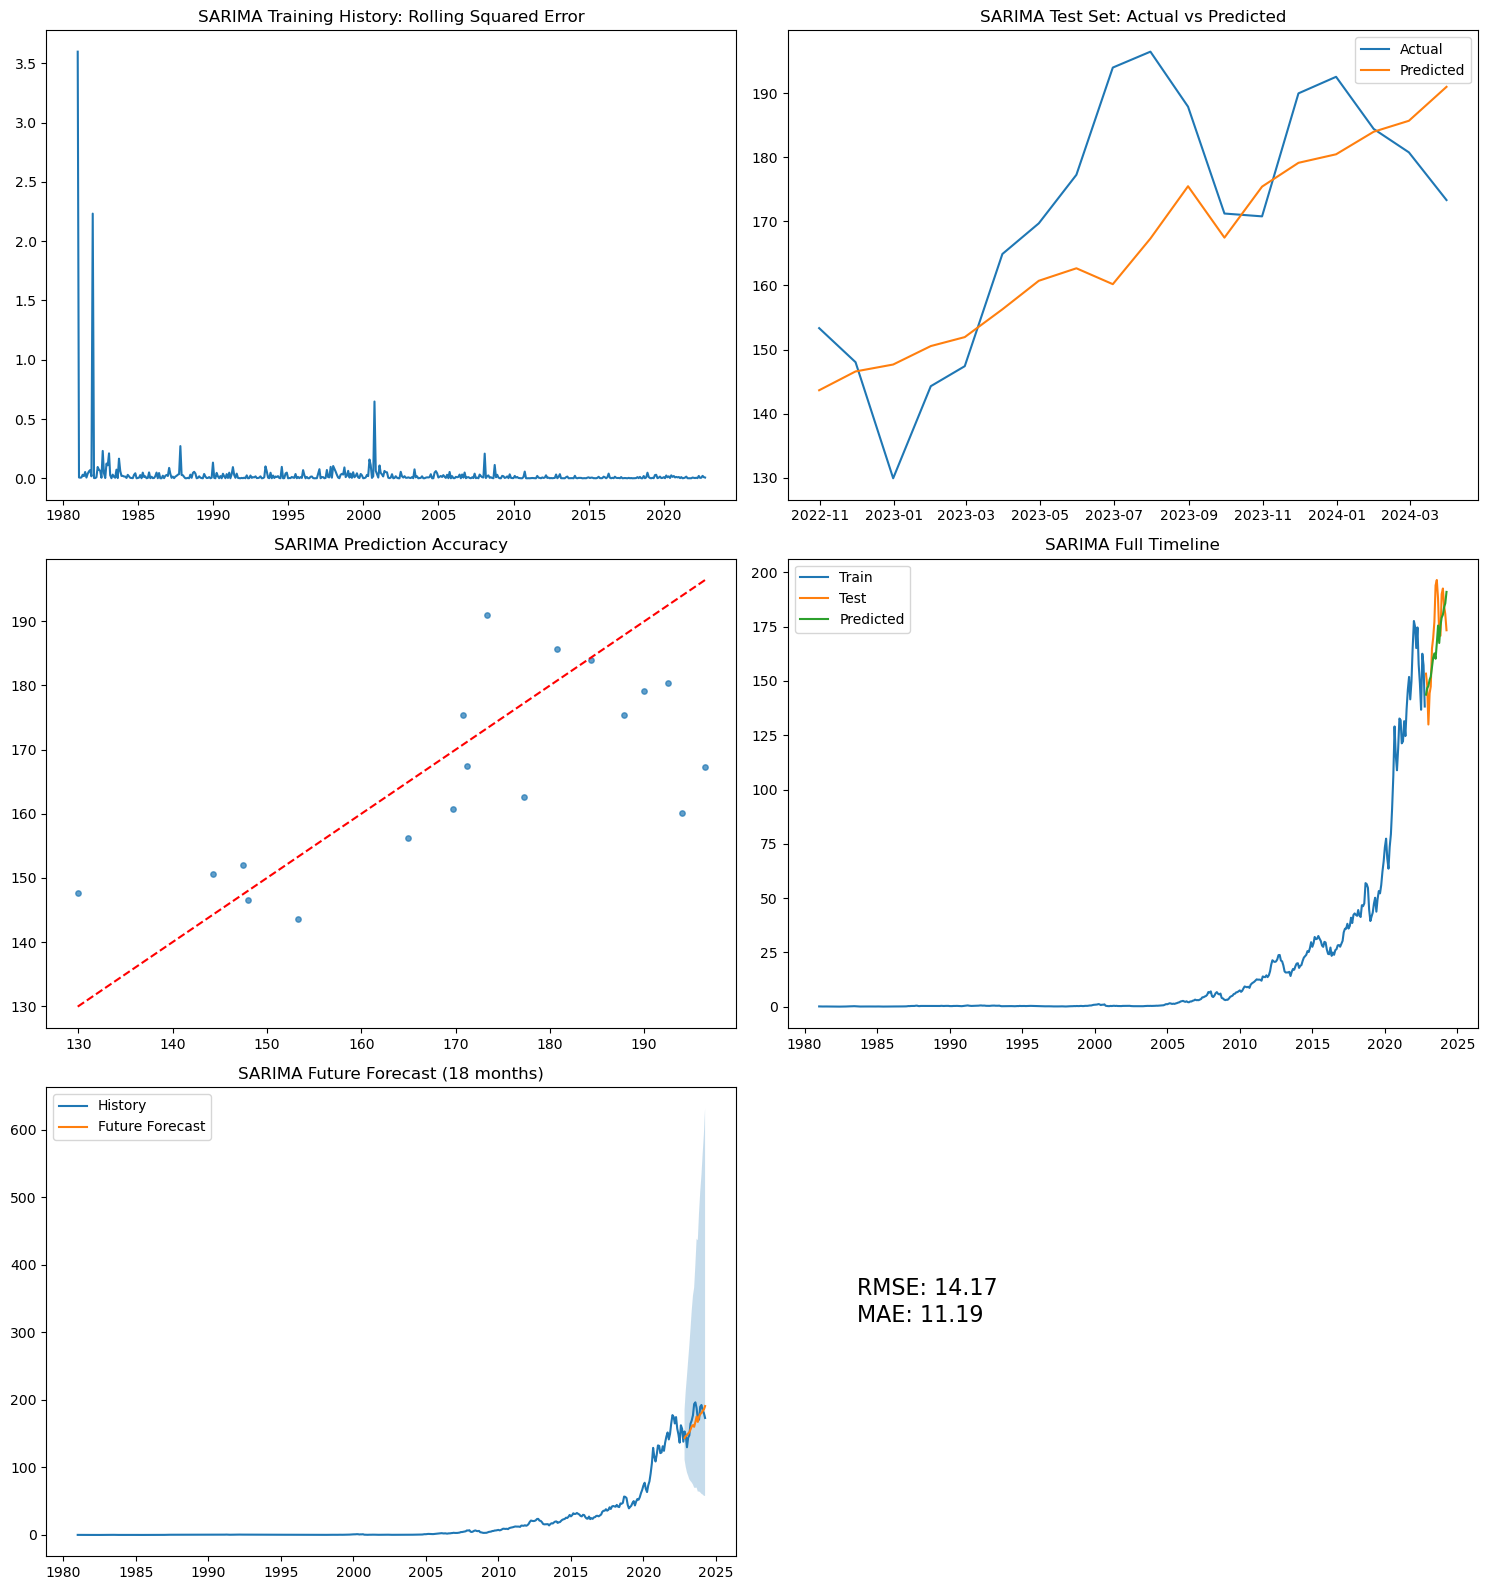


=== [SARIMA] Future Forecast Table (Same Length as Test Set) ===
              Forecast   Lower 95%   Upper 95%
2022-10-31  143.655145  111.567966  184.970664
2022-11-30  146.589710  100.792943  213.194916
2022-12-31  147.667580   92.585455  235.519868
2023-01-31  150.544801   87.400350  259.309454
2023-02-28  151.942455   82.468700  279.942687
2023-03-31  156.272104   79.830740  305.909359
2023-04-30  160.724942   77.667017  332.605886
2023-05-31  162.672734   74.653552  354.469648
2023-06-30  160.195646   70.043013  366.384082
2023-07-31  167.314988   69.886150  400.570146
2023-08-31  175.467124   70.175208  438.740581
2023-09-30  167.454436   64.249709  436.437591
2023-10-31  175.407087   64.440587  477.457566
2023-11-30  179.118900   63.100066  508.455575
2023-12-31  180.448073   61.053227  533.329829
2024-01-31  183.965159   59.867177  565.304423
2024-02-29  185.673196   58.193108  592.416126
2024-03-31  190.964024   57.710741  631.897245

================ [SARIMA] ACTUAL vs PRED

In [16]:
# ==========================================================
# 4. MODEL 1: SARIMA + RISK METRICS
# ==========================================================

def sarima_grid_search(y, p_values, d_values, q_values,
                       P_values, D_values, Q_values, s=12):

    best_aic = np.inf
    best_order = None
    best_seasonal = None
    best_model = None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        for P, D, Q in itertools.product(P_values, D_values, Q_values):
            order = (p, d, q)
            seasonal_order = (P, D, Q, s)

            try:
                model = SARIMAX(
                    y,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                result = model.fit(disp=False)
                aic = result.aic

                print(f"SARIMA{order}x{seasonal_order}12 → AIC = {aic:.2f}")

                if aic < best_aic:
                    best_aic = aic
                    best_order = order
                    best_seasonal = seasonal_order
                    best_model = result

            except:
                continue

    print("\n=========== SARIMA GRID SEARCH COMPLETE ===========")
    print("Best AIC:", best_aic)
    print("Best order:", best_order)
    print("Best seasonal order:", best_seasonal)

    return best_model, best_order, best_seasonal


# Parameter ranges
p_values = [0, 1, 2]
d_values = [1]
q_values = [0, 1, 2]

P_values = [0, 1]
D_values = [1]
Q_values = [0, 1]

print("\nStarting SARIMA grid search...\n")

best_model_sar, best_order_sar, best_seasonal_sar = sarima_grid_search(
    y_train_sar,
    p_values, d_values, q_values,
    P_values, D_values, Q_values,
    s=12
)

res_sar = best_model_sar
print("\n[SARIMA] Selected Hyperparameters:")
print("Order:", best_order_sar)
print("Seasonal:", best_seasonal_sar)
print("AIC:", res_sar.aic)

# ---- Forecast test set ----
test_steps_sar = len(y_test_sar)

fcast_sar = res_sar.get_forecast(steps=test_steps_sar)
pred_log_sar = fcast_sar.predicted_mean

pred_sar   = np.exp(pred_log_sar)
actual_sar = np.exp(y_test_sar)

rmse_sar = np.sqrt(mean_squared_error(actual_sar, pred_sar))
mae_sar  = mean_absolute_error(actual_sar, pred_sar)

print("\n=== [SARIMA] Test Performance (USD) ===")
print("RMSE:", round(rmse_sar, 3))
print("MAE :", round(mae_sar, 3))

# ---- Future forecast (same length as test set) ----
future_steps_sar = test_steps_sar
future_sar = res_sar.get_forecast(steps=future_steps_sar)
future_mean_sar = np.exp(future_sar.predicted_mean)
future_ci_sar   = np.exp(future_sar.conf_int())

# ---- Plots ----
fig, axs = plt.subplots(3, 2, figsize=(15, 16))
axs = axs.flatten()

rolling_err_sar = (y_train_sar - res_sar.fittedvalues)**2
axs[0].plot(rolling_err_sar.dropna())
axs[0].set_title("SARIMA Training History: Rolling Squared Error")

axs[1].plot(actual_sar.index, actual_sar, label="Actual")
axs[1].plot(pred_sar.index,   pred_sar,   label="Predicted")
axs[1].set_title("SARIMA Test Set: Actual vs Predicted")
axs[1].legend()

axs[2].scatter(actual_sar, pred_sar, s=15, alpha=0.7)
axs[2].plot([actual_sar.min(), actual_sar.max()],
            [actual_sar.min(), actual_sar.max()], "r--")
axs[2].set_title("SARIMA Prediction Accuracy")

axs[3].plot(np.exp(y_train_sar), label="Train")
axs[3].plot(np.exp(y_test_sar),  label="Test")
axs[3].plot(pred_sar.index,      pred_sar, label="Predicted")
axs[3].set_title("SARIMA Full Timeline")
axs[3].legend()

axs[4].plot(np.exp(y_log), label="History")
axs[4].plot(future_mean_sar.index, future_mean_sar, label="Future Forecast")
axs[4].fill_between(
    future_mean_sar.index,
    future_ci_sar.iloc[:, 0],
    future_ci_sar.iloc[:, 1],
    alpha=0.25
)
axs[4].set_title(f"SARIMA Future Forecast ({test_steps_sar} months)")
axs[4].legend()

axs[5].axis("off")
axs[5].text(0.1, 0.5, f"RMSE: {rmse_sar:.2f}\nMAE: {mae_sar:.2f}", fontsize=16)

plt.tight_layout()
plt.show()

future_df_sar = pd.DataFrame({
    "Forecast":  future_mean_sar,
    "Lower 95%": future_ci_sar.iloc[:, 0],
    "Upper 95%": future_ci_sar.iloc[:, 1],
})
print("\n=== [SARIMA] Future Forecast Table (Same Length as Test Set) ===")
print(future_df_sar)

# ---- SARIMA risk metrics (actual vs predicted) ----
print("\n================ [SARIMA] ACTUAL vs PREDICTED RISK METRICS ================\n")

predicted_prices_sar = np.array(pred_sar, dtype=float).copy()
predicted_prices_sar[predicted_prices_sar <= 0] = 1e-6
returns_pred_sar = np.diff(np.log(predicted_prices_sar))
returns_pred_sar = returns_pred_sar[~np.isnan(returns_pred_sar)]

vol_pred_sar = np.std(returns_pred_sar)
var95_pred_sar = np.percentile(returns_pred_sar, 5)
running_max_pred_sar = np.maximum.accumulate(predicted_prices_sar)
drawdowns_pred_sar = predicted_prices_sar / running_max_pred_sar - 1.0
max_dd_pred_sar = np.min(drawdowns_pred_sar)
sharpe_pred_sar = np.mean(returns_pred_sar)/vol_pred_sar if vol_pred_sar > 0 else 0
cum_ret_pred_sar = predicted_prices_sar[-1]/predicted_prices_sar[0] - 1.0

actual_prices_sar = np.array(actual_sar, dtype=float).copy()
actual_prices_sar[actual_prices_sar <= 0] = 1e-6
returns_act_sar = np.diff(np.log(actual_prices_sar))
returns_act_sar = returns_act_sar[~np.isnan(returns_act_sar)]

vol_act_sar = np.std(returns_act_sar)
var95_act_sar = np.percentile(returns_act_sar, 5)
running_max_act_sar = np.maximum.accumulate(actual_prices_sar)
drawdowns_act_sar = actual_prices_sar / running_max_act_sar - 1.0
max_dd_act_sar = np.min(drawdowns_act_sar)
sharpe_act_sar = np.mean(returns_act_sar)/vol_act_sar if vol_act_sar > 0 else 0
cum_ret_act_sar = actual_prices_sar[-1]/actual_prices_sar[0] - 1.0

risk_table_sar = pd.DataFrame({
    "Actual": [
        vol_act_sar,
        var95_act_sar,
        max_dd_act_sar,
        sharpe_act_sar,
        cum_ret_act_sar
    ],
    "Predicted": [
        vol_pred_sar,
        var95_pred_sar,
        max_dd_pred_sar,
        sharpe_pred_sar,
        cum_ret_pred_sar
    ]
}, index=[
    "Volatility",
    "VaR (95%)",
    "Max Drawdown",
    "Sharpe Ratio",
    "Cumulative Return"
])

print(risk_table_sar.round(6))
print("\n==================================================================\n")

### Transformer Architecture
Input sequence (15 days x 5 features)
Sinusoidal positional encoding
o    Necessary to add temporal ordering to transformers as transformers naturally doesn’t understand order
Transformers encoder block (4 heads, head size = 128)
o    Compute relationships between all time steps using dot-product attention
o    Residual connection + LayerNorm is added for stability
Feed-forward network (FFN):
o    Dense (128, ReLU) -> Dense (5)
o    Second residual connection ensures smooth 

Key Parameters:
Lookback window = 15
Attention: head_size = 128, num_heads = 4
FFN dimension: 128
Optimizer: Adam, lr = 0.00005
Batch size = 64, epochs = 50, early stopping = 20 patience
Normalization: MinMaxScaler

Pros:
Parallelizable
Robust to noise
Captures complex cross features correlations

Cons: 
Permutation-invariant without positional encoding
Short-lookback (15 days)
Computationally more expensive than TCN/LSTM

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 15, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 15, 5)     │          0 │ input_layer_7[0]… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 5)     │         10 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 5)     │     11,781 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 15, 5)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 15, 5)     │          0 │ dropout_21[0][0], │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 5)     │         10 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 15, 128)   │        768 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 15, 128)   │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 15, 5)     │        645 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 15, 5)     │          0 │ dense_17[0][0],   │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 75)        │          0 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 75)        │          0 │ flatten_5[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      4,864 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         65 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,143 (70.87 KB)

 Trainable params: 18,143 (70.87 KB)

 Non-trainable params: 0 (0.00 B)

Training Transformer model...
Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2894 - mae: 0.4268

2025-12-01 19:43:34.136135: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 4 bytes spill stores, 4 bytes spill loads



154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - loss: 0.2284 - mae: 0.3777 - val_loss: 0.9294 - val_mae: 0.8971 - learning_rate: 5.0000e-05
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1364 - mae: 0.2884 - val_loss: 0.2350 - val_mae: 0.4614 - learning_rate: 5.0000e-05
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0775 - mae: 0.2178 - val_loss: 0.0702 - val_mae: 0.2494 - learning_rate: 5.0000e-05
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0538 - mae: 0.1812 - val_loss: 0.0251 - val_mae: 0.1367 - learning_rate: 5.0000e-05
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0427 - mae: 0.1609 - val_loss: 0.0196 - val_mae: 0.1153 - learning_rate: 5.0000e-05
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0338 - mae: 0.1422 - val_loss: 0.0199 - val_mae: 0.1150 - learning_rate: 5.0000e-05
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0285 - mae: 0.1293 - val_loss: 0.0198 - val_mae: 0.1153 - learning_rate

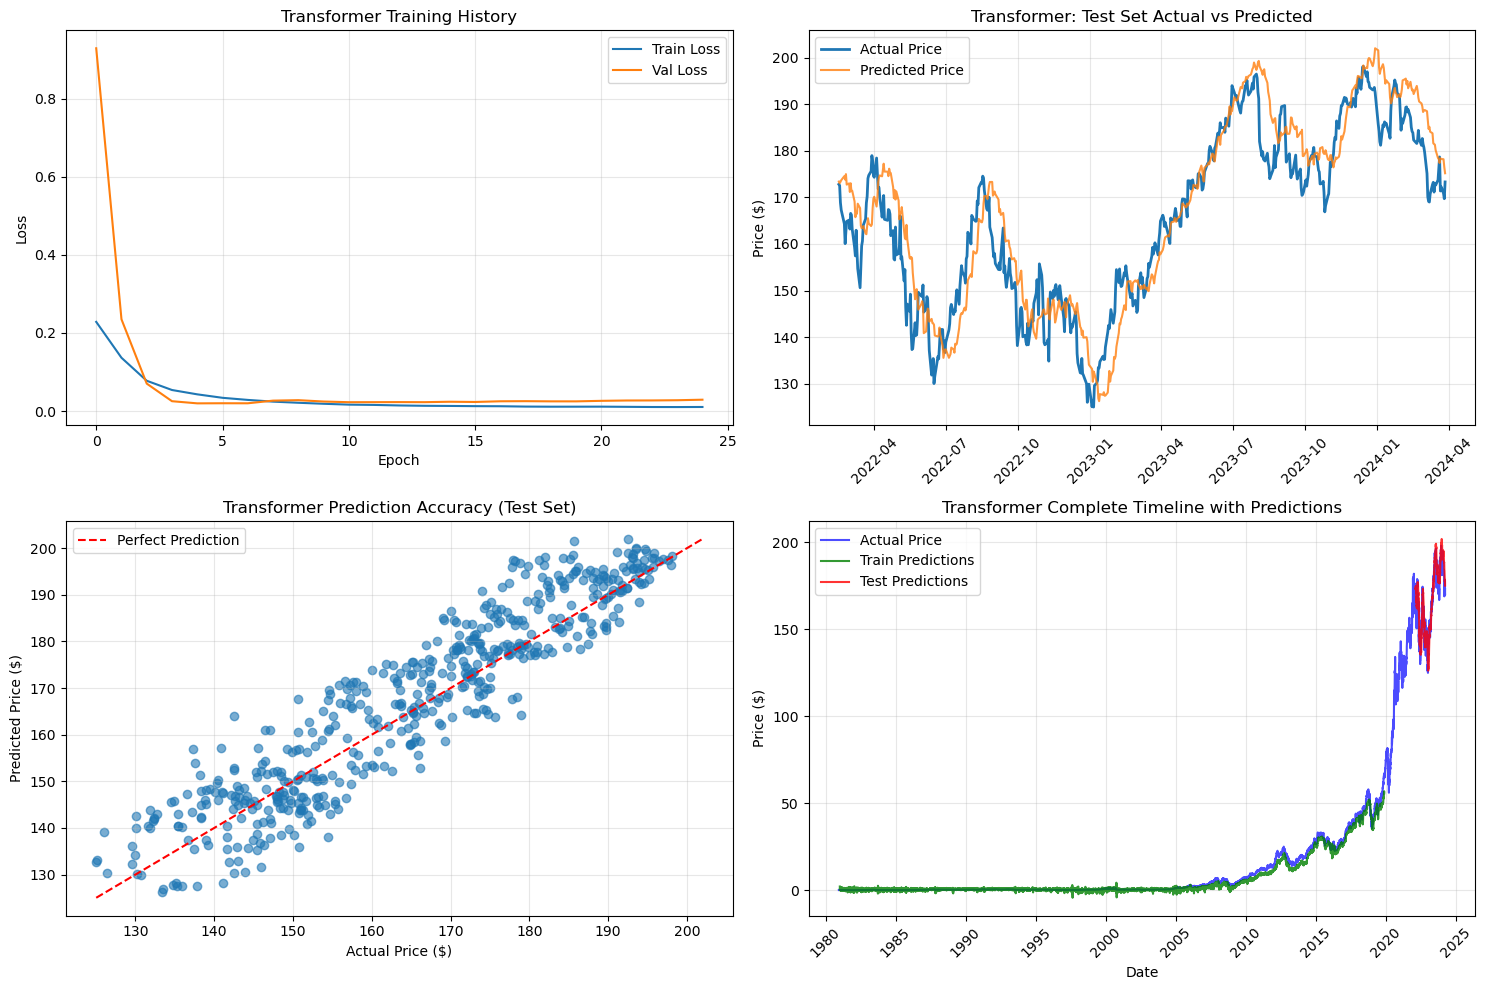

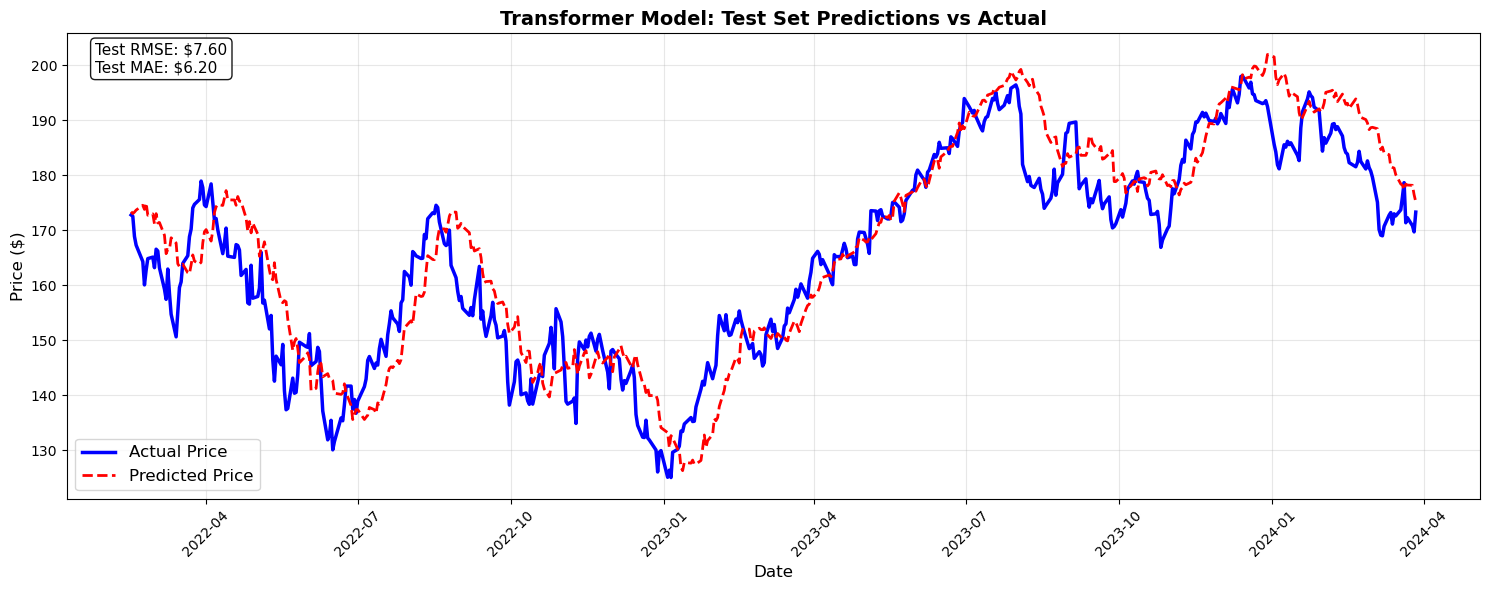


[Transformer] Data ordered from 1980-12-12 00:00:00 to 2024-03-27 00:00:00
[Transformer] Model trained on 9803 sequences, tested on 531 sequences


In [17]:
# ==========================================================
# 5. MODEL 2: TRANSFORMER
# ==========================================================

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout
    )(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

inputs_tf = Input(shape=(X_train_tf.shape[1], X_train_tf.shape[2]))
x_tf = PositionalEncoding()(inputs_tf)
x_tf = transformer_encoder(x_tf, head_size=128, num_heads=4, ff_dim=128, dropout=0.1)
x_tf = Flatten()(x_tf)
x_tf = Dropout(0.2)(x_tf)
x_tf = Dense(64, activation="relu")(x_tf)
x_tf = Dropout(0.2)(x_tf)
outputs_tf = Dense(1, activation="linear")(x_tf)

transformer_model = Model(inputs=inputs_tf, outputs=outputs_tf)
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=0.00005)
transformer_model.compile(optimizer=optimizer_tf, loss="mean_squared_error", metrics=['mae'])

transformer_model.summary()

callbacks_tf = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
]

print("Training Transformer model...")
history_tf = transformer_model.fit(
    X_train_tf, y_train_tf,
    shuffle=False,
    validation_data=(X_val_tf, y_val_tf),
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=callbacks_tf
)

# Predict on train & test
train_pred_scaled_tf = transformer_model.predict(X_train_tf, verbose=0)
test_pred_scaled_tf  = transformer_model.predict(X_test_tf,  verbose=0)

# Inverse-scale
y_train_rescaled_tf = scaler_target.inverse_transform(y_train_tf.reshape(-1, 1)).flatten()
y_test_rescaled_tf  = scaler_target.inverse_transform(y_test_tf.reshape(-1, 1)).flatten()

train_pred_rescaled_tf = scaler_target.inverse_transform(train_pred_scaled_tf).flatten()
test_pred_rescaled_tf  = scaler_target.inverse_transform(test_pred_scaled_tf).flatten()

# Performance metrics
train_rmse_tf = math.sqrt(mean_squared_error(y_train_rescaled_tf, train_pred_rescaled_tf))
test_rmse_tf  = math.sqrt(mean_squared_error(y_test_rescaled_tf,  test_pred_rescaled_tf))
train_mae_tf  = mean_absolute_error(y_train_rescaled_tf, train_pred_rescaled_tf)
test_mae_tf   = mean_absolute_error(y_test_rescaled_tf,  test_pred_rescaled_tf)

print("\n" + "="*50)
print("TRANSFORMER MODEL PERFORMANCE")
print("="*50)
print(f"Train RMSE: ${train_rmse_tf:.2f}")
print(f"Test  RMSE: ${test_rmse_tf:.2f}")
print(f"Train MAE:  ${train_mae_tf:.2f}")
print(f"Test  MAE:  ${test_mae_tf:.2f}")

# Build aligned date indexes
dates_all = df_all["Date"].values

train_start_idx_tf = TIME_STEP_TRANS
train_end_idx_tf   = train_start_idx_tf + len(train_pred_rescaled_tf)
train_dates_tf = dates_all[train_start_idx_tf:train_end_idx_tf]

test_start_idx_tf = train_size + val_size + TIME_STEP_TRANS
test_end_idx_tf   = test_start_idx_tf + len(test_pred_rescaled_tf)
test_dates_tf = dates_all[test_start_idx_tf:test_end_idx_tf]

# Plotting
plt.figure(figsize=(15, 10))

# Training history
plt.subplot(2, 2, 1)
plt.plot(history_tf.history["loss"], label="Train Loss")
plt.plot(history_tf.history["val_loss"], label="Val Loss")
plt.title("Transformer Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)

# Test set: Actual vs Predicted
plt.subplot(2, 2, 2)
plt.plot(test_dates_tf, y_test_rescaled_tf, label="Actual Price", linewidth=2)
plt.plot(test_dates_tf, test_pred_rescaled_tf, label="Predicted Price", linewidth=1.5, alpha=0.8)
plt.title("Transformer: Test Set Actual vs Predicted")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Scatter
plt.subplot(2, 2, 3)
plt.scatter(y_test_rescaled_tf, test_pred_rescaled_tf, alpha=0.6)
min_val_tf = min(y_test_rescaled_tf.min(), test_pred_rescaled_tf.min())
max_val_tf = max(y_test_rescaled_tf.max(), test_pred_rescaled_tf.max())
plt.plot([min_val_tf, max_val_tf], [min_val_tf, max_val_tf], "r--", label="Perfect Prediction")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Transformer Prediction Accuracy (Test Set)")
plt.legend()
plt.grid(True, alpha=0.3)

# Full timeline
plt.subplot(2, 2, 4)
plt.plot(dates_all, df_all[target_column].values, label="Actual Price", color="blue", alpha=0.7)
plt.plot(train_dates_tf, train_pred_rescaled_tf, label="Train Predictions", color="green", alpha=0.8)
plt.plot(test_dates_tf, test_pred_rescaled_tf, label="Test Predictions", color="red", alpha=0.8)
plt.title("Transformer Complete Timeline with Predictions")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Clean test plot with metrics
plt.figure(figsize=(15, 6))
plt.plot(test_dates_tf, y_test_rescaled_tf, label="Actual Price", linewidth=2.5, color="blue")
plt.plot(test_dates_tf, test_pred_rescaled_tf, label="Predicted Price", linewidth=2, color="red", linestyle="--")
plt.title("Transformer Model: Test Set Predictions vs Actual", fontsize=14, fontweight="bold")
plt.ylabel("Price ($)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.text(
    0.02, 0.98,
    f"Test RMSE: ${test_rmse_tf:.2f}\nTest MAE: ${test_mae_tf:.2f}",
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9),
)

plt.tight_layout()
plt.show()

print(f"\n[Transformer] Data ordered from {df_all['Date'].min()} to {df_all['Date'].max()}")
print(f"[Transformer] Model trained on {len(X_train_tf)} sequences, tested on {len(X_test_tf)} sequences")

### TCN Model 

- **Goal:** Predict next stock countinously for roughly 2 years (514 days) price using past 60 days of features.
- **Architecture:**
  - 2× causal Conv1D layers (64 filters, kernel size 3, ReLU)
  - Dropout (0.2) + L2 regularization (0.01)
  - Flatten → Dense(50) → Dense(1)
- **Key Hyperparameters:**  
  Lookback = 60, filters = 64, kernel = 3, dropout = 0.2, L2 = 0.01, batch = 32, epochs = 20.
- **Pros:** parallelizable, stable on noisy data.
- **Cons:** Fixed window length, no long-range memory, less expressive than attention models.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 30, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 30, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 50)             │        96,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,477 (427.64 KB)

 Trainable params: 109,477 (427.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1928 - mae: 0.0195 - rmse: 0.0407 - val_loss: 0.0564 - val_mae: 0.1980 - val_rmse: 0.2253
Epoch 2/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0043 - mae: 0.0116 - rmse: 0.0217 - val_loss: 0.0444 - val_mae: 0.1760 - val_rmse: 0.2034
Epoch 3/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0034 - mae: 0.0123 - rmse: 0.0227 - val_loss: 0.0348 - val_mae: 0.1506 - val_rmse: 0.1787
Epoch 4/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0032 - mae: 0.0130 - rmse: 0.0238 - val_loss: 0.0583 - val_mae: 0.2079 - val_rmse: 0.2363
Epoch 5/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0029 - mae: 0.0122 - rmse: 0.0224 - val_loss: 0.0747 - val_mae: 0.2395 - val_rmse: 0.2690
Epoch 6/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0028 - mae: 0.0127 - rmse: 0.0232 - val_loss: 0.0774 - val_mae: 0.2440 - val_rmse: 0.2740
Epoch 7/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0029 - mae: 0.0141 - rms

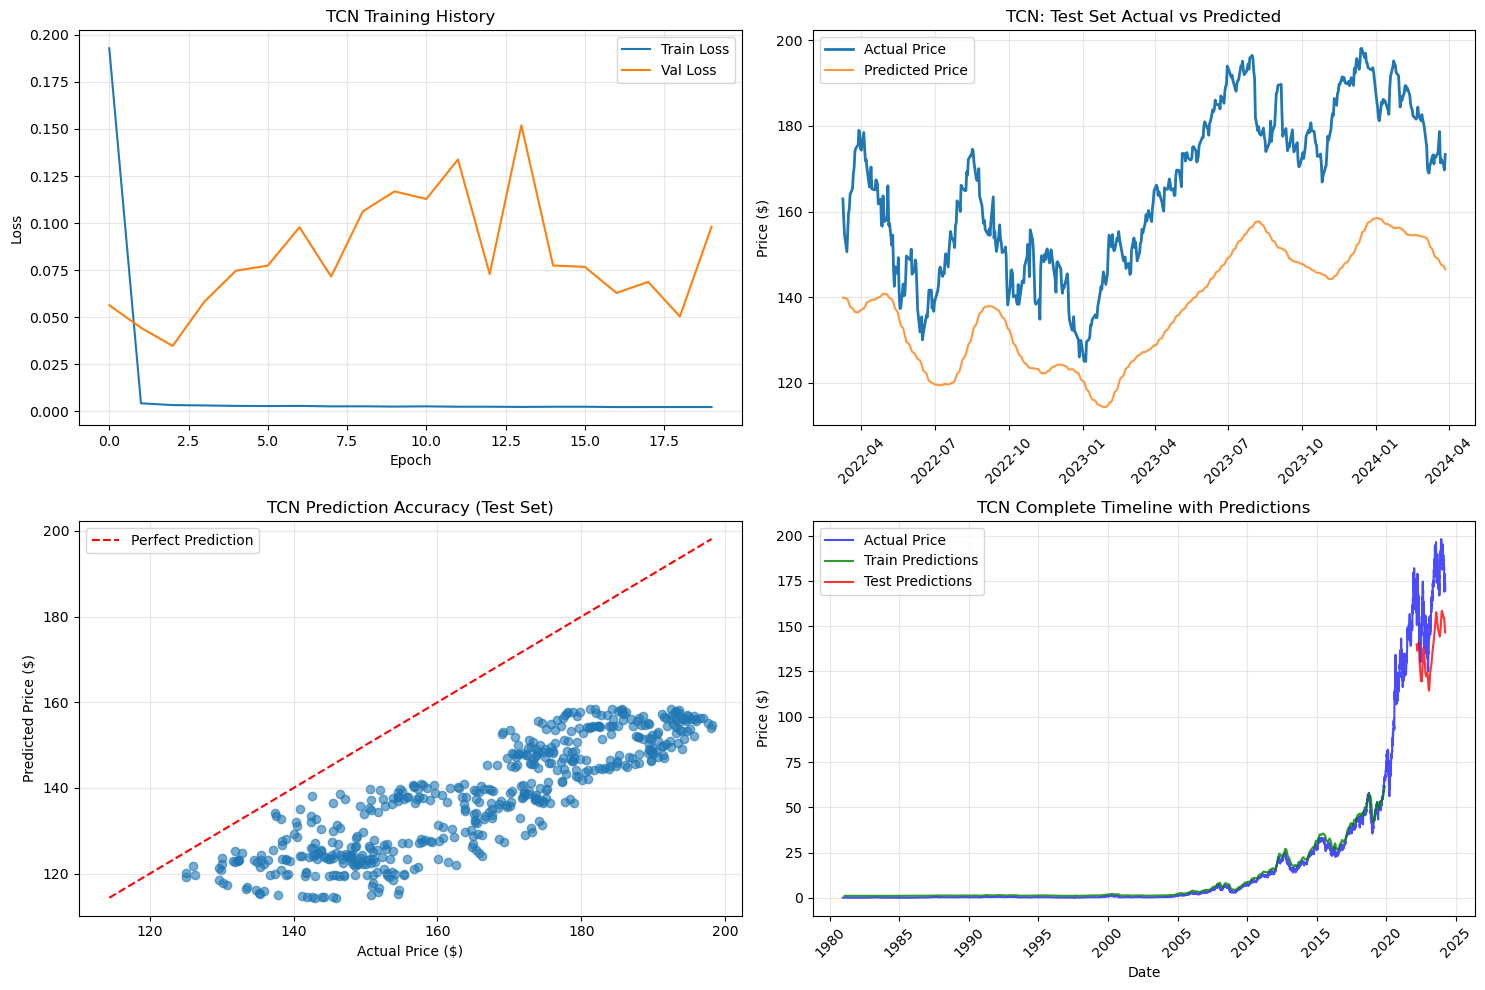

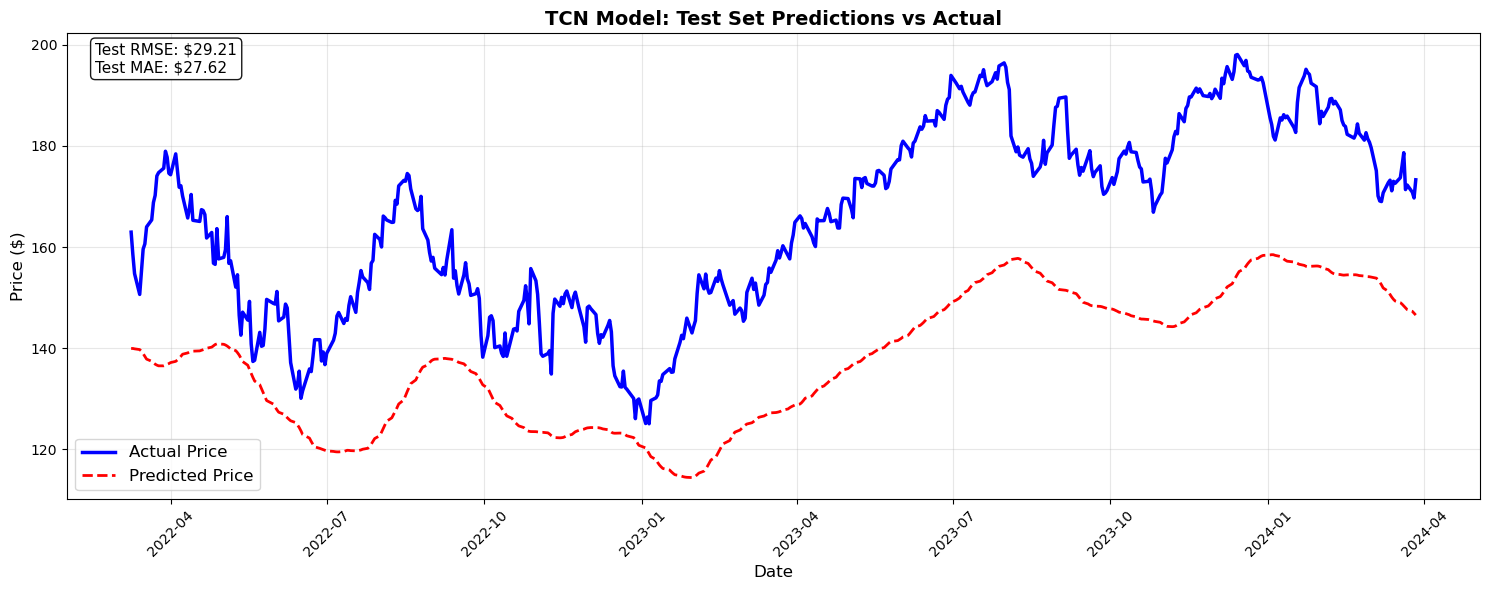


================ [TCN] ACTUAL vs PREDICTED RISK METRICS ================

Metric                            Actual           Predicted
------------------------------------------------------------
Volatility                      0.017751            0.002753
VaR (95%)                      -0.031007           -0.004739
Max Drawdown                   -0.301408           -0.187902
Sharpe Ratio                    0.006743            0.032663
Cumulative Return               0.063578            0.047398




In [18]:
# ==========================================================
# 6. MODEL 3: TCN + RISK METRICS
# ==========================================================

timesteps_tcn    = X_train_tcn.shape[1]
num_features_tcn = X_train_tcn.shape[2]

tcn_model = Sequential()
tcn_model.add(Conv1D(
    filters=64,
    kernel_size=3,
    padding='causal',
    activation='relu',
    input_shape=(timesteps_tcn, num_features_tcn),
    kernel_regularizer=regularizers.l2(0.01)
))
tcn_model.add(Dropout(0.2))

tcn_model.add(Conv1D(
    filters=64,
    kernel_size=3,
    padding='causal',
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)
))
tcn_model.add(Dropout(0.2))

tcn_model.add(Flatten())
tcn_model.add(Dense(50, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
tcn_model.add(Dense(1))  # single Price (scaled)

tcn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

tcn_model.summary()

logdir_tcn = os.path.join("logs_tcn", datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(logdir_tcn, exist_ok=True)

tensorboard_cb_tcn = tf.keras.callbacks.TensorBoard(
    log_dir=logdir_tcn,
    histogram_freq=1
)

history_tcn = tcn_model.fit(
    X_train_tcn, y_train_tcn,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_tcn, y_val_tcn),
    callbacks=[tensorboard_cb_tcn],
    verbose=1
)

loss_tcn, mae_tcn, rmse_tcn = tcn_model.evaluate(X_test_tcn, y_test_tcn, verbose=1)
print(f"\n[TCN] Test loss (MSE): {loss_tcn:.6f}")
print(f"[TCN] Test MAE:       {mae_tcn:.6f}")
print(f"[TCN] Test RMSE:      {rmse_tcn:.6f}")

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# ==========================================================
# Predict on TRAIN + TEST and inverse-scale (TCN)
# ==========================================================
train_pred_scaled_tcn = tcn_model.predict(X_train_tcn, verbose=0)
test_pred_scaled_tcn  = tcn_model.predict(X_test_tcn,  verbose=0)

# Inverse-scale to dollars
y_train_rescaled_tcn = scaler_target.inverse_transform(
    y_train_tcn.reshape(-1, 1)
).flatten()
y_test_rescaled_tcn = scaler_target.inverse_transform(
    y_test_tcn.reshape(-1, 1)
).flatten()

train_pred_rescaled_tcn = scaler_target.inverse_transform(
    train_pred_scaled_tcn
).flatten()
pred_rescaled_tcn = scaler_target.inverse_transform(
    test_pred_scaled_tcn
).flatten()

# Test metrics in original units
rmse_test_tcn = math.sqrt(mean_squared_error(y_test_rescaled_tcn, pred_rescaled_tcn))
mae_test_tcn  = mean_absolute_error(y_test_rescaled_tcn,  pred_rescaled_tcn)

# ==========================================================
# Align dates (same logic as Transformer, but using TCN lookback)
# ==========================================================
dates_all = df_all["Date"].values      # same df_all used in Transformer
lookback_tcn = timesteps_tcn           # X_train_tcn.shape[1]

# Train prediction date range
train_start_idx_tcn = lookback_tcn
train_end_idx_tcn   = train_start_idx_tcn + len(train_pred_rescaled_tcn)
train_dates_tcn     = dates_all[train_start_idx_tcn:train_end_idx_tcn]

# Test prediction date range (after train + val)
test_start_idx_tcn = train_size + val_size + lookback_tcn
test_end_idx_tcn   = test_start_idx_tcn + len(pred_rescaled_tcn)
test_dates_tcn     = dates_all[test_start_idx_tcn:test_end_idx_tcn]

# ==========================================================
# 4-panel figure (mirrors Transformer layout)
# ==========================================================
plt.figure(figsize=(15, 10))

# (1) Training history
plt.subplot(2, 2, 1)
plt.plot(history_tcn.history["loss"], label="Train Loss")
plt.plot(history_tcn.history["val_loss"], label="Val Loss")
plt.title("TCN Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)

# (2) Test set: Actual vs Predicted
plt.subplot(2, 2, 2)
plt.plot(test_dates_tcn, y_test_rescaled_tcn, label="Actual Price", linewidth=2)
plt.plot(test_dates_tcn, pred_rescaled_tcn, label="Predicted Price", linewidth=1.5, alpha=0.8)
plt.title("TCN: Test Set Actual vs Predicted")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# (3) Scatter: Predictions vs Actual
plt.subplot(2, 2, 3)
plt.scatter(y_test_rescaled_tcn, pred_rescaled_tcn, alpha=0.6)
min_val_tcn = min(y_test_rescaled_tcn.min(), pred_rescaled_tcn.min())
max_val_tcn = max(y_test_rescaled_tcn.max(), pred_rescaled_tcn.max())
plt.plot([min_val_tcn, max_val_tcn], [min_val_tcn, max_val_tcn], "r--", label="Perfect Prediction")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("TCN Prediction Accuracy (Test Set)")
plt.legend()
plt.grid(True, alpha=0.3)

# (4) Full timeline
plt.subplot(2, 2, 4)
plt.plot(dates_all, df_all[target_column].values, label="Actual Price", color="blue", alpha=0.7)
plt.plot(train_dates_tcn, train_pred_rescaled_tcn, label="Train Predictions", color="green", alpha=0.8)
plt.plot(test_dates_tcn, pred_rescaled_tcn, label="Test Predictions", color="red", alpha=0.8)
plt.title("TCN Complete Timeline with Predictions")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ==========================================================
# Clean test plot with metrics (like Transformer)
# ==========================================================
plt.figure(figsize=(15, 6))
plt.plot(test_dates_tcn, y_test_rescaled_tcn, label="Actual Price", linewidth=2.5, color="blue")
plt.plot(test_dates_tcn, pred_rescaled_tcn, label="Predicted Price", linewidth=2, color="red", linestyle="--")
plt.title("TCN Model: Test Set Predictions vs Actual", fontsize=14, fontweight="bold")
plt.ylabel("Price ($)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.text(
    0.02, 0.98,
    f"Test RMSE: ${rmse_test_tcn:.2f}\nTest MAE: ${mae_test_tcn:.2f}",
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9),
)

plt.tight_layout()
plt.show()


# ====== PREDICTED TEST SET RISK EVALUATION (TCN) ======
predicted_prices_tcn = np.array(pred_rescaled_tcn, dtype=float).copy()
predicted_prices_tcn[predicted_prices_tcn <= 0] = 1e-6

returns_pred_tcn = np.diff(np.log(predicted_prices_tcn))
returns_pred_tcn = returns_pred_tcn[~np.isnan(returns_pred_tcn)]

volatility_pred_tcn = np.std(returns_pred_tcn)
var_95_pred_tcn = np.percentile(returns_pred_tcn, 5)

running_max_tcn = np.maximum.accumulate(predicted_prices_tcn)
drawdowns_tcn = predicted_prices_tcn / running_max_tcn - 1.0
max_drawdown_pred_tcn = np.min(drawdowns_tcn)

if volatility_pred_tcn != 0:
    sharpe_ratio_pred_tcn = np.mean(returns_pred_tcn) / volatility_pred_tcn
else:
    sharpe_ratio_pred_tcn = 0.0

cumulative_return_pred_tcn = predicted_prices_tcn[-1] / predicted_prices_tcn[0] - 1.0

# ====== ACTUAL RISK METRICS (TCN TEST SET) ======
actual_prices_tcn = np.array(y_test_rescaled_tcn, dtype=float).copy()
actual_prices_tcn[actual_prices_tcn <= 0] = 1e-6

actual_returns_tcn = np.diff(np.log(actual_prices_tcn))
actual_returns_tcn = actual_returns_tcn[~np.isnan(actual_returns_tcn)]

actual_volatility_tcn = np.std(actual_returns_tcn)
actual_var_95_tcn = np.percentile(actual_returns_tcn, 5)

running_max_actual_tcn = np.maximum.accumulate(actual_prices_tcn)
actual_drawdowns_tcn = actual_prices_tcn / running_max_actual_tcn - 1.0
actual_max_drawdown_tcn = np.min(actual_drawdowns_tcn)

if actual_volatility_tcn != 0:
    actual_sharpe_ratio_tcn = np.mean(actual_returns_tcn) / actual_volatility_tcn
else:
    actual_sharpe_ratio_tcn = 0.0

actual_cumulative_return_tcn = actual_prices_tcn[-1] / actual_prices_tcn[0] - 1.0

print("\n================ [TCN] ACTUAL vs PREDICTED RISK METRICS ================\n")
print(f"{'Metric':<25}{'Actual':>15}{'Predicted':>20}")
print("-"*60)
print(f"{'Volatility':<25}{actual_volatility_tcn:>15.6f}{volatility_pred_tcn:>20.6f}")
print(f"{'VaR (95%)':<25}{actual_var_95_tcn:>15.6f}{var_95_pred_tcn:>20.6f}")
print(f"{'Max Drawdown':<25}{actual_max_drawdown_tcn:>15.6f}{max_drawdown_pred_tcn:>20.6f}")
print(f"{'Sharpe Ratio':<25}{actual_sharpe_ratio_tcn:>15.6f}{sharpe_ratio_pred_tcn:>20.6f}")
print(f"{'Cumulative Return':<25}{actual_cumulative_return_tcn:>15.6f}{cumulative_return_pred_tcn:>20.6f}")
print("\n================================================================\n")

### LSTM Architecture
2× LSTM layers (128 & 64 filters respectively)


L2 regularization (0.0001) + 2X Dropout layers (0.2 & 0.1 respectively)


Dense (1) output for single-step forecasting
Key Hyperparameters:
Lookback = 60
Filters= 128/64
Dropout = 0.2/0.1
L2 Regularization = 0.0001
Batch = 32
Epochs = 20,
Learning rate= 0.0002

Pros
Effective at learning long term dependencies 
Good at handling moderate levels of noise
Cons
Requires significant hyperparameter tuning to optimize the performance
Prone to overfitting, especially on smaller datasets
Longer training times and generally computationally expensive


[LSTM] X_train_lstm: (9788, 30, 5) X_val_lstm: (515, 30, 5) X_test_lstm: (516, 30, 5)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0273 - mae: 0.0205 - val_loss: 0.2168 - val_mae: 0.3880 - learning_rate: 2.0000e-04
Epoch 2/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0125 - mae: 0.0127 - val_loss: 0.1383 - val_mae: 0.3057 - learning_rate: 2.0000e-04
Epoch 3/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0076 - mae: 0.0110 - val_loss: 0.1229 - val_mae: 0.2923 - learning_rate: 2.0000e-04
Epoch 4/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0054 - mae: 0.0111 - val_loss: 0.1277 - val_mae: 0.3038 - learning_rate: 2.0000e-04
Epoch 5/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0042 - mae: 0.0101 - val_loss: 0.0972 - val_mae: 0.2608 - learning_rate: 2.0000e-04
Epoch 6/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0033 - mae: 0.0098 - val_loss: 0.1199 - val_mae: 0.2971 - learning_rate: 2.0000e-04
Epoch 7/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0027 - mae: 0.0098 - val_loss: 0.1195 - val_mae: 0.300

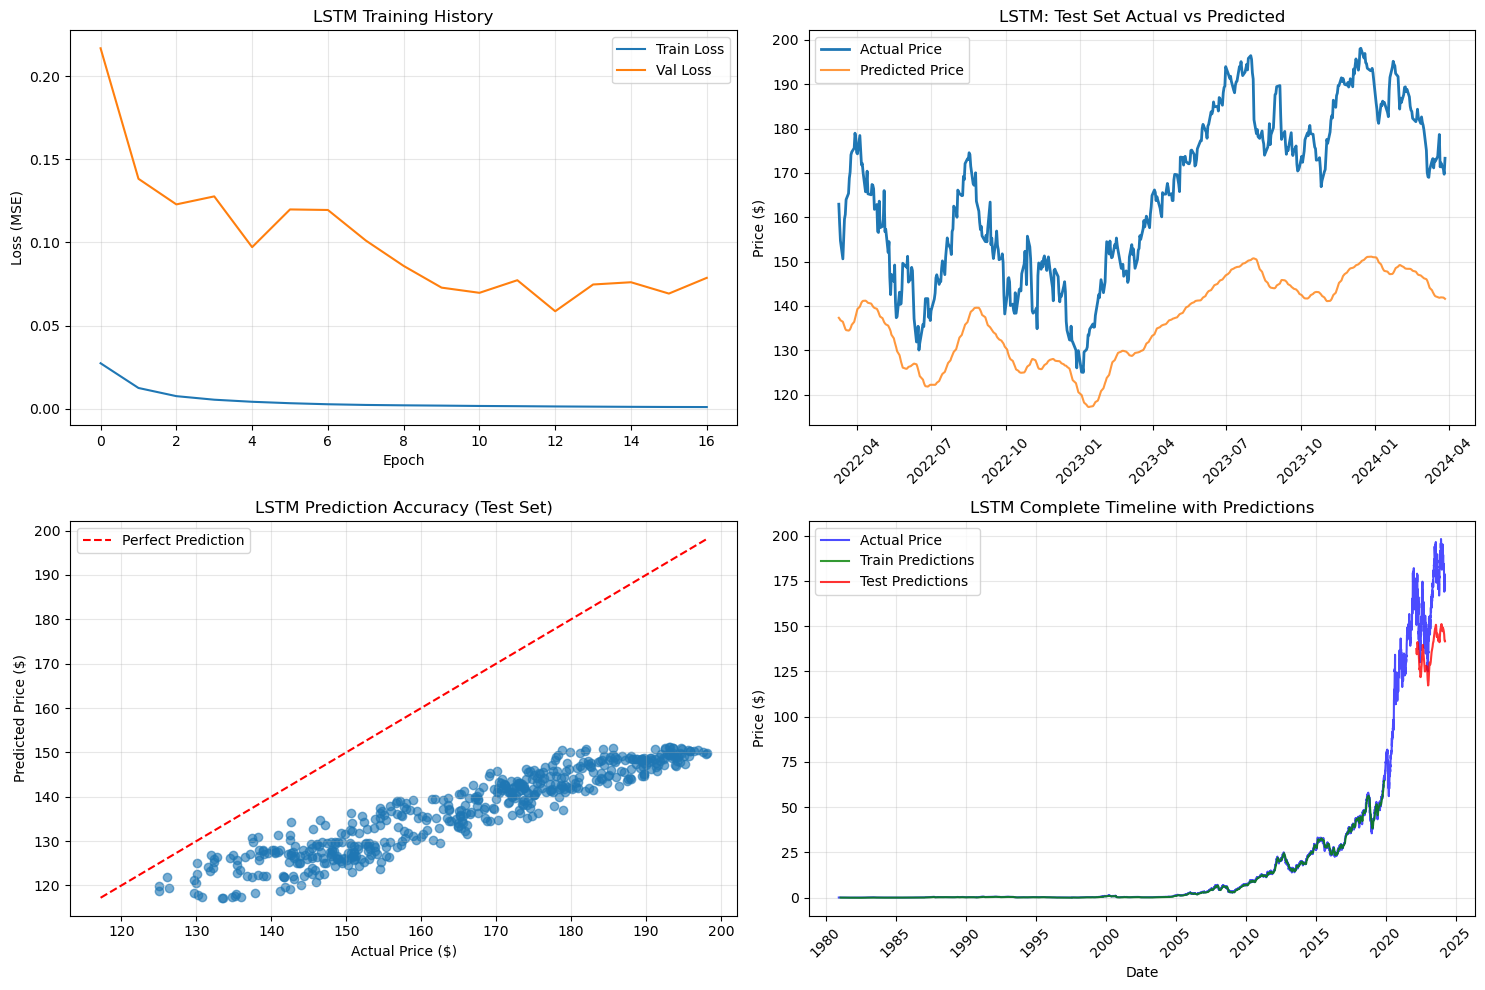

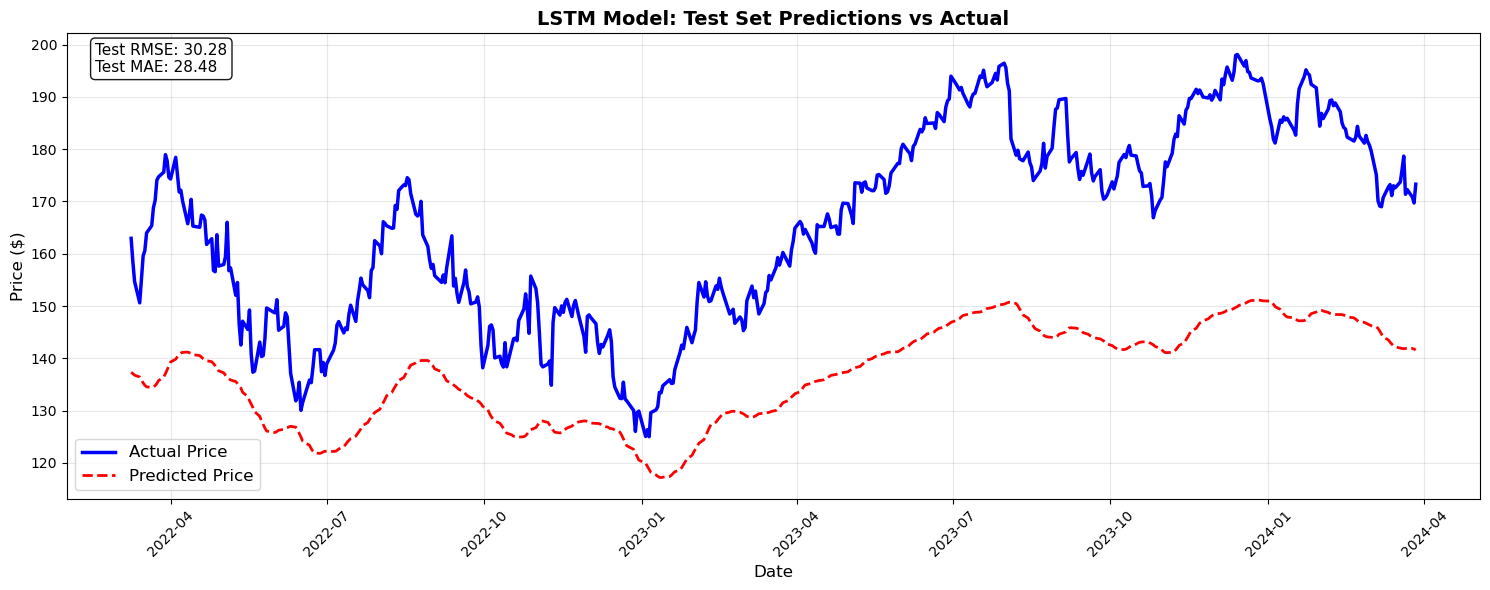

In [19]:
# ==========================================================
# 7. MODEL 4: LSTM
# ==========================================================
from tensorflow.keras import layers, regularizers

LOOKBACK_LSTM = 30  # separate lookback window for LSTM

# Build sequences for LSTM using the same scaled data and helper
X_train_lstm, y_train_lstm = create_sequences(train_scaled_data, LOOKBACK_LSTM)
X_val_lstm,   y_val_lstm   = create_sequences(val_scaled_data,   LOOKBACK_LSTM)
X_test_lstm,  y_test_lstm  = create_sequences(test_scaled_data,  LOOKBACK_LSTM)

print("\n[LSTM] X_train_lstm:", X_train_lstm.shape,
      "X_val_lstm:", X_val_lstm.shape,
      "X_test_lstm:", X_test_lstm.shape)
RANDOM_SEED =42
tf.random.set_seed(RANDOM_SEED)

def build_lstm_model(n_features):
    model = tf.keras.Sequential([
        layers.Input(shape=(LOOKBACK_LSTM, n_features)),
        layers.LSTM(
            128,
            return_sequences=True,
            kernel_regularizer=regularizers.l2(1e-4),
            recurrent_regularizer=regularizers.l2(1e-4)
        ),
        layers.Dropout(0.2),
        layers.LSTM(
            64,
            kernel_regularizer=regularizers.l2(1e-4),
            recurrent_regularizer=regularizers.l2(1e-4)
        ),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

lstm_model = build_lstm_model(n_features=X_train_lstm.shape[-1])
lstm_model.summary()

callbacks_lstm = [
    tf.keras.callbacks.EarlyStopping(
        patience=4,
        restore_best_weights=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=2,
        min_lr=1e-5,
        monitor="val_loss"
    )
]

history_lstm = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=20,
    batch_size=32,
    callbacks=callbacks_lstm,
    verbose=1
)

# ---------- Evaluate + inverse scale ----------
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Predict in scaled space
train_pred_scaled_lstm = lstm_model.predict(X_train_lstm, verbose=0).ravel()
test_pred_scaled_lstm  = lstm_model.predict(X_test_lstm,  verbose=0).ravel()

# Inverse target scaling using scaler_target (last column is target)
y_train_rescaled_lstm = scaler_target.inverse_transform(
    y_train_lstm.reshape(-1, 1)
).flatten()
y_test_rescaled_lstm = scaler_target.inverse_transform(
    y_test_lstm.reshape(-1, 1)
).flatten()

train_pred_rescaled_lstm = scaler_target.inverse_transform(
    train_pred_scaled_lstm.reshape(-1, 1)
).flatten()
test_pred_rescaled_lstm = scaler_target.inverse_transform(
    test_pred_scaled_lstm.reshape(-1, 1)
).flatten()

rmse_train_lstm = math.sqrt(mean_squared_error(y_train_rescaled_lstm, train_pred_rescaled_lstm))
rmse_test_lstm  = math.sqrt(mean_squared_error(y_test_rescaled_lstm,  test_pred_rescaled_lstm))
mae_train_lstm  = mean_absolute_error(y_train_rescaled_lstm, train_pred_rescaled_lstm)
mae_test_lstm   = mean_absolute_error(y_test_rescaled_lstm,  test_pred_rescaled_lstm)

print("\n" + "="*50)
print("LSTM MODEL PERFORMANCE")
print("="*50)
print(f"Train RMSE: {rmse_train_lstm:.4f}")
print(f"Test  RMSE: {rmse_test_lstm:.4f}")
print(f"Train MAE:  {mae_train_lstm:.4f}")
print(f"Test  MAE:  {mae_test_lstm:.4f}")

# ---------- Align dates for plotting ----------
dates_all = df_all["Date"].values  # already defined earlier

# First LSTM train target corresponds to index LOOKBACK_LSTM
train_start_idx_lstm = LOOKBACK_LSTM
train_end_idx_lstm   = train_start_idx_lstm + len(train_pred_rescaled_lstm)
train_dates_lstm     = dates_all[train_start_idx_lstm:train_end_idx_lstm]

# Test set starts at (train_size + val_size), we add LOOKBACK_LSTM inside that segment
test_start_idx_lstm = train_size + val_size + LOOKBACK_LSTM
test_end_idx_lstm   = test_start_idx_lstm + len(test_pred_rescaled_lstm)
test_dates_lstm     = dates_all[test_start_idx_lstm:test_end_idx_lstm]

# ---------- Plots ----------
# Training history
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history_lstm.history["loss"], label="Train Loss")
plt.plot(history_lstm.history["val_loss"], label="Val Loss")
plt.title("LSTM Training History")
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)

# Test set: actual vs predicted
plt.subplot(2, 2, 2)
plt.plot(test_dates_lstm, y_test_rescaled_lstm, label="Actual Price", linewidth=2)
plt.plot(test_dates_lstm, test_pred_rescaled_lstm, label="Predicted Price", linewidth=1.5, alpha=0.8)
plt.title("LSTM: Test Set Actual vs Predicted")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Scatter
plt.subplot(2, 2, 3)
plt.scatter(y_test_rescaled_lstm, test_pred_rescaled_lstm, alpha=0.6)
min_val_lstm = min(y_test_rescaled_lstm.min(), test_pred_rescaled_lstm.min())
max_val_lstm = max(y_test_rescaled_lstm.max(), test_pred_rescaled_lstm.max())
plt.plot([min_val_lstm, max_val_lstm], [min_val_lstm, max_val_lstm], "r--", label="Perfect Prediction")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("LSTM Prediction Accuracy (Test Set)")
plt.legend()
plt.grid(True, alpha=0.3)

# Full timeline
plt.subplot(2, 2, 4)
plt.plot(dates_all, df_all[target_column].values, label="Actual Price", color="blue", alpha=0.7)
plt.plot(train_dates_lstm, train_pred_rescaled_lstm, label="Train Predictions", color="green", alpha=0.8)
plt.plot(test_dates_lstm, test_pred_rescaled_lstm, label="Test Predictions", color="red", alpha=0.8)
plt.title("LSTM Complete Timeline with Predictions")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Clean test plot with metrics
plt.figure(figsize=(15, 6))
plt.plot(test_dates_lstm, y_test_rescaled_lstm, label="Actual Price", linewidth=2.5, color="blue")
plt.plot(test_dates_lstm, test_pred_rescaled_lstm, label="Predicted Price", linewidth=2, color="red", linestyle="--")
plt.title("LSTM Model: Test Set Predictions vs Actual", fontsize=14, fontweight="bold")
plt.ylabel("Price ($)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.text(
    0.02, 0.98,
    f"Test RMSE: {rmse_test_lstm:.2f}\nTest MAE: {mae_test_lstm:.2f}",
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9),
)

plt.tight_layout()
plt.show()


### Risk Metrics and Why They Matter to an Investor

This section takes the **price paths** from each model (SARIMA, Transformer, TCN, LSTM) and converts them into **risk–return metrics** that an investor actually cares about:

- **Volatility**  
  - Measures how much returns fluctuate over time (standard deviation of log returns).  
  - Higher volatility = more uncertainty and a bumpier ride for the investor.

- **Value-at-Risk (VaR 95%)**  
  - 5th percentile of returns → “On a bad day, how much could I lose with 95% confidence?”  
  - More negative VaR = larger potential downside shock.

- **Max Drawdown**  
  - Worst peak-to-trough drop in the price path.  
  - Captures how painful the largest loss episode would feel for a buy-and-hold investor.

- **Sharpe Ratio**  
  - Average return divided by volatility.  
  - Higher Sharpe = better **risk-adjusted** performance (more return per unit of risk).

- **Cumulative Return**  
  - Total % gain or loss over the test period.  
  - Shows what an investor would have made (or lost) following that price path.

The code:

- Computes these metrics for the **actual test prices** and for the **predicted price paths** of each model.
- Prints side-by-side tables (`Actual` vs `Predicted`) for each model.
- Plots bar charts so we can visually compare how well each model captures:
  - The **true downside risk** (VaR, drawdown),
  - The **true volatility**, and
  - The **overall return and risk-adjusted performance**.

For an investor, this is crucial: it turns raw predictive models into a **risk profile** and lets us judge not just *how accurate* the models are, but whether they **underestimate or overestimate risk**, which directly affects position sizing, stop-loss decisions, and whether the strategy is acceptable in a real portfolio.


================ [SARIMA] ACTUAL vs PREDICTED RISK METRICS ================

Metric                                 Actual      Predicted
------------------------------------------------------------
Volatility                           0.017751       0.022156
VaR (95%)                           -0.031007      -0.021624
Max Drawdown                        -0.301408      -0.045665
Sharpe Ratio                         0.006743       0.755798
Cumulative Return                    0.063578       0.329323



================ [Transformer] ACTUAL vs PREDICTED RISK METRICS ================

Metric                                 Actual      Predicted
------------------------------------------------------------
Volatility                           0.017751       0.009608
VaR (95%)                           -0.031007      -0.017179
Max Drawdown                        -0.301408      -0.287425
Sharpe Ratio                         0.006743       0.002005
Cumulative Return                    0.06357

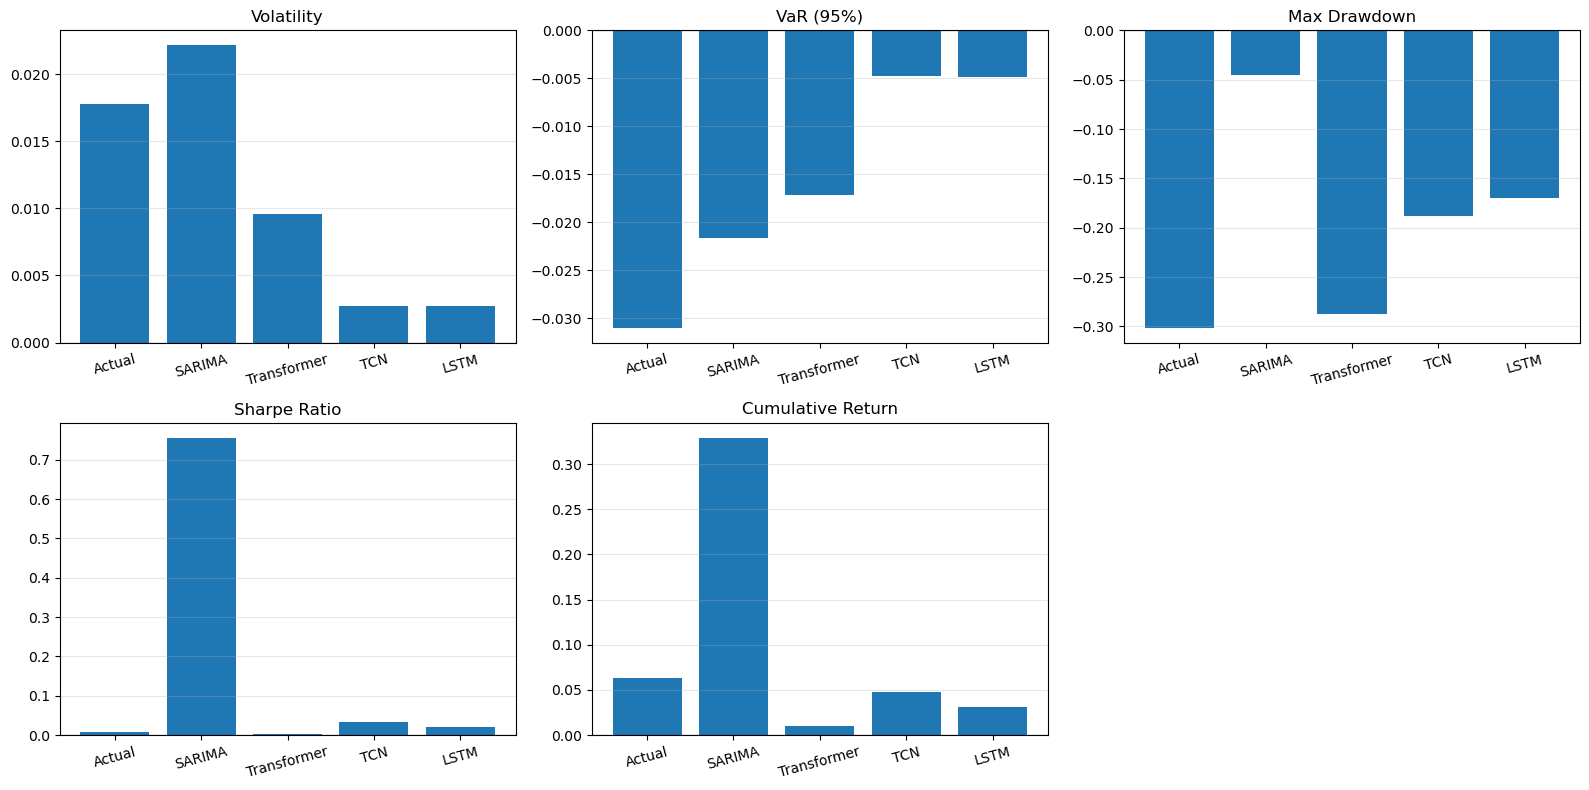

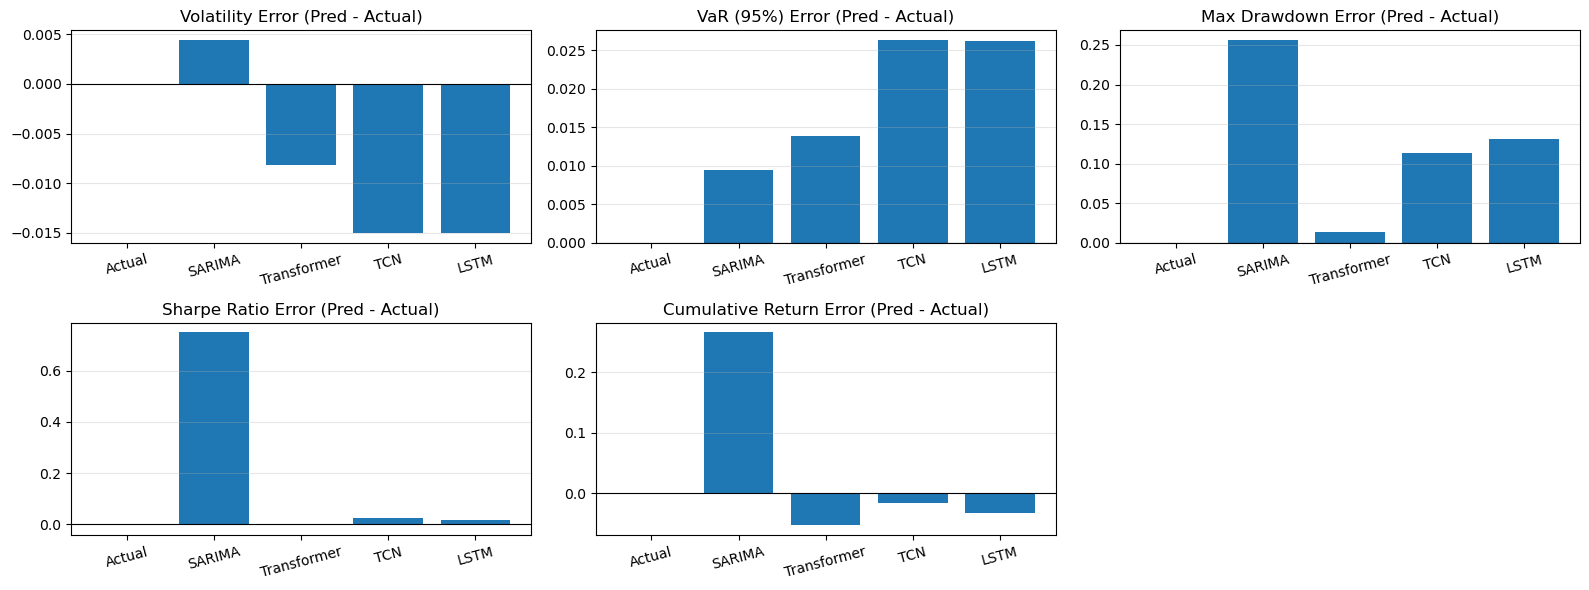

In [20]:
# ==========================================================
# COMMON RISK METRICS + COMPARISON ACROSS ALL MODELS
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def risk_from_prices(prices):
    """
    prices: 1D array-like of prices over time.
    Returns a dict with the 5 risk metrics.
    """
    prices = np.array(prices, dtype=float).copy()
    prices[prices <= 0] = 1e-6

    # log returns
    rets = np.diff(np.log(prices))
    rets = rets[~np.isnan(rets)]

    volatility = np.std(rets)
    var_95 = np.percentile(rets, 5)

    running_max = np.maximum.accumulate(prices)
    drawdowns = prices / running_max - 1.0
    max_dd = np.min(drawdowns)

    sharpe = np.mean(rets) / volatility if volatility != 0 else 0.0
    cumulative_return = prices[-1] / prices[0] - 1.0

    return {
        "Volatility":        volatility,
        "VaR (95%)":         var_95,
        "Max Drawdown":      max_dd,
        "Sharpe Ratio":      sharpe,
        "Cumulative Return": cumulative_return
    }


def print_risk_table(model_name, actual_metrics, pred_metrics):
    """
    Print ASCII table:
    ================ [MODEL] ACTUAL vs PREDICTED RISK METRICS ================
    """
    print(f"\n================ [{model_name}] ACTUAL vs PREDICTED RISK METRICS ================\n")
    print(f"{'Metric':<30}{'Actual':>15}{'Predicted':>15}")
    print("-" * 60)
    for metric in ["Volatility", "VaR (95%)", "Max Drawdown", "Sharpe Ratio", "Cumulative Return"]:
        a = actual_metrics[metric]
        p = pred_metrics[metric]
        print(f"{metric:<30}{a:>15.6f}{p:>15.6f}")
    print("\n================================================================\n")


# ----------------------------------------------------------
# 1. CHOOSE ONE SHARED ACTUAL SERIES
# Doesnt matter which actual series we use because they are all the same
# ----------------------------------------------------------
actual_test_prices = y_test_rescaled_tcn    

actual_metrics = risk_from_prices(actual_test_prices)

# ----------------------------------------------------------
# 2. COMPUTE PREDICTED METRICS FOR EACH MODEL
# ----------------------------------------------------------
# SARIMA – monthly predictions
sar_pred_metrics  = risk_from_prices(pred_sar)

# Transformer – daily predictions
tf_pred_metrics   = risk_from_prices(test_pred_rescaled_tf)

# TCN – daily predictions
tcn_pred_metrics  = risk_from_prices(pred_rescaled_tcn)

# LSTM – daily predictions
lstm_pred_metrics = risk_from_prices(test_pred_rescaled_lstm)

# ----------------------------------------------------------
# 3. PRINT TABLES (MATCHING YOUR TEXT FORMAT)
# ----------------------------------------------------------
print_risk_table("SARIMA",      actual_metrics, sar_pred_metrics)
print_risk_table("Transformer", actual_metrics, tf_pred_metrics)
print_risk_table("TCN",         actual_metrics, tcn_pred_metrics)
print_risk_table("LSTM",        actual_metrics, lstm_pred_metrics)

# ----------------------------------------------------------
# 4. BAR CHART: ONE ACTUAL vs ALL MODELS
# ----------------------------------------------------------
models = ["Actual", "SARIMA", "Transformer", "TCN", "LSTM"]
metrics_order = ["Volatility", "VaR (95%)", "Max Drawdown", "Sharpe Ratio", "Cumulative Return"]

plt.figure(figsize=(16, 8))

for i, metric in enumerate(metrics_order):
    plt.subplot(2, 3, i+1)

    vals = [
        actual_metrics[metric],
        sar_pred_metrics[metric],
        tf_pred_metrics[metric],
        tcn_pred_metrics[metric],
        lstm_pred_metrics[metric],
    ]

    x = np.arange(len(models))
    plt.bar(x, vals)

    plt.title(metric)
    plt.xticks(x, models, rotation=15)
    plt.grid(axis="y", alpha=0.3)
    plt.axhline(0, color="black", linewidth=0.8)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 5. OPTIONAL: ERROR BAR CHART (PRED - ACTUAL)
# ----------------------------------------------------------
plt.figure(figsize=(16, 6))

for i, metric in enumerate(metrics_order):
    plt.subplot(2, 3, i+1)

    actual_val = actual_metrics[metric]
    errors = [
        0.0,  # Actual - Actual
        sar_pred_metrics[metric]  - actual_val,
        tf_pred_metrics[metric]   - actual_val,
        tcn_pred_metrics[metric]  - actual_val,
        lstm_pred_metrics[metric] - actual_val,
    ]

    x = np.arange(len(models))
    plt.bar(x, errors)

    plt.title(metric + " Error (Pred - Actual)")
    plt.xticks(x, models, rotation=15)
    plt.grid(axis="y", alpha=0.3)
    plt.axhline(0, color="black", linewidth=0.8)

plt.tight_layout()
plt.show()